# Análisis del dataset de entrenamiento


## 1. Análisis de frecuencias de palabras


En textos de de humor es común que se sigan ciertos patrones o se utilicen ciertas palabras como "JAJA" o "#humor" que los modelos pueden asociar erróneamente a niveles de humor durante el finetuning. En este notebook realizamos un análisis de frecuencia de palabras por cada clase en el dataset de entrenamiento ubicado en la ruta `./data/processed/haha_train.csv` para identificar estas palabras. El objetivo de este análisis es extender el dataset de entrenamiento con instancias que incluyan estas palabras frecuentes y adicionarles ruido para hacer más resistente el modelo a estos patrones y mejorar su rendimiento en las tareas de detección y clasificación.


In [1]:
import pandas as pd
import random
import os

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
random.seed(21)

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danny\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
processed_file_path = '../data/processed/haha_train.csv'

processed_df = pd.read_csv(processed_file_path, sep=',', encoding='utf-8')

processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    24000 non-null  object
 1   score   24000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 375.1+ KB


In [5]:
print("Cantidad de textos por clase:")
text_counts = processed_df['score'].value_counts()
text_counts = text_counts.sort_index()
pd.DataFrame(text_counts)

Cantidad de textos por clase:


,count
score,
0,14747
1,2861
2,4201
3,1971
4,204
5,16


In [6]:
score_classes = text_counts.index.to_list()
score_classes

[0, 1, 2, 3, 4, 5]

In [7]:
detection_classes = [0, 1]

In [8]:
def custom_tokenizer(text):
  # Regex para hacer match de hashtags, emojis, y palabras.
  pattern = r"(\#[a-zA-Z0-9_]+|[^\w\s,]|[\w]+|[\U00010000-\U0010ffff])"
  return re.findall(pattern, text)

Se define un conjunto de palabras o partes de palabras con significado relacionado a humor, como sinónimos o antónimos de humor, modos de humor, hashtags relacionados con humor, acrónimos de humor, algunas palabras comunes en inglés de humor y algunos emojis que expresa sentimiento de humor.

In [9]:
HUMOR_WORDS_EXACT = ["risa", "ríe", "riendo", "joda", "LOL"]
HUMOR_WORDS_PARTIAL = ["jaja", "jajá", "haha", "carcajada", "partirse", "riéndose",
                       "humor", "chiste", "broma", "comedia", "burla", "chanza", "chascarrillo",
                       "gracioso", "graciosa", "divertido", "divertida", "diversión",
                       "sarcasmo", "sarcástico", "ironía", "irónico", "sátira", "satírico",
                       "#meme" "#fun", "#funny", "#comedy", "#cringe", "#irony", "#random",
                       "joke", "kidding", "laugh", "hilarious", "humorous", "random",
                       "LMAO", "ROFL", "XD", "OMG",
                       "😀", "😊", "😆", "😁", "😂", "🤣",
                       "🤔", "😅", "😩",
                       "☹️", "😞", "😔", "🥺", "😢", "😭"]

In [10]:
def contains_humor_words(token: str) -> bool:
  result = False
  token1 = token.lower()

  humor_words_exact_lower = [word.lower() for word in HUMOR_WORDS_EXACT]

  for word in humor_words_exact_lower:
    if word == token1:
      result = True
      return result

  humor_words_partial_lower = [word.lower() for word in HUMOR_WORDS_PARTIAL]

  for word in humor_words_partial_lower:
    if word in token1:
      result = True
      return result

  return result

In [11]:
def get_tokens_per_class(data_df: pd.DataFrame, score_classes: list[str]) -> dict:
  """
  Obtiene conjuntos de tokens completo y tokens de humor por clase.
  """
  result = {}
  for score_class in score_classes:
    partition_df = data_df[data_df['score'] == score_class]
    text_values = partition_df['text'].to_list()

    tokens = [custom_tokenizer(text) for text in text_values]
    tokens = [token for token_list in tokens for token in token_list]

    humor_tokens = [token for token in tokens if contains_humor_words(token)]

    result[score_class] = {
        'tokens': tokens,
        'humor_tokens': humor_tokens
    }

  return result

In [12]:
tokens_per_class = get_tokens_per_class(processed_df, score_classes)

In [13]:
def plot_wordclouds(tokens_per_class: dict, all_tokens: bool):
  """
  Muestra las nubes de tokens para cada clase.
  """
  fig, axes = plt.subplots(2, 3, figsize=(12, 7))

  for i, score_class in enumerate(score_classes):
    x = i // 3
    y = i % 3
    prop = 'tokens' if all_tokens else 'humor_tokens'
    wc_text = ' '.join(tokens_per_class[score_class][prop])
    wordcloud = WordCloud(width=400,
                          height=400,
                          background_color='white',
                          random_state=37).generate(wc_text)

    axes[x, y].imshow(wordcloud, interpolation='bilinear')
    axes[x, y].axis('off')
    axes[x, y].set_title(f'Score {score_class}', fontsize=18)

  plt.tight_layout()
  plt.show()

Nubes de palabras presentes por clase:


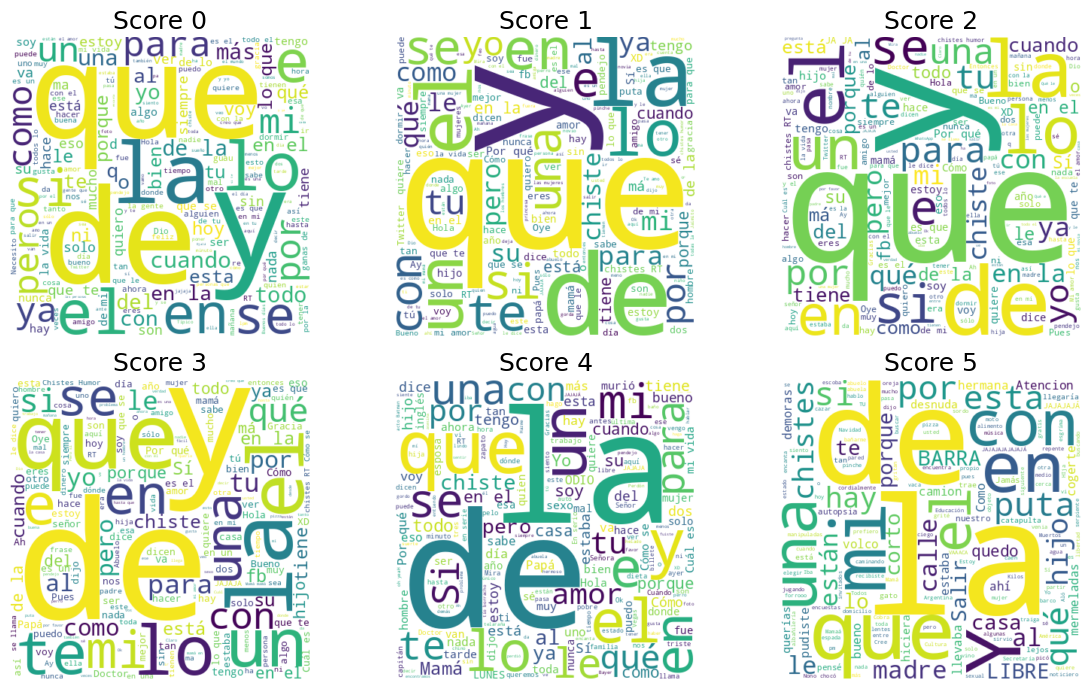

In [14]:
print("Nubes de palabras presentes por clase:")
plot_wordclouds(tokens_per_class, all_tokens=True)

Nubes de tokens de humor presentes por clase:


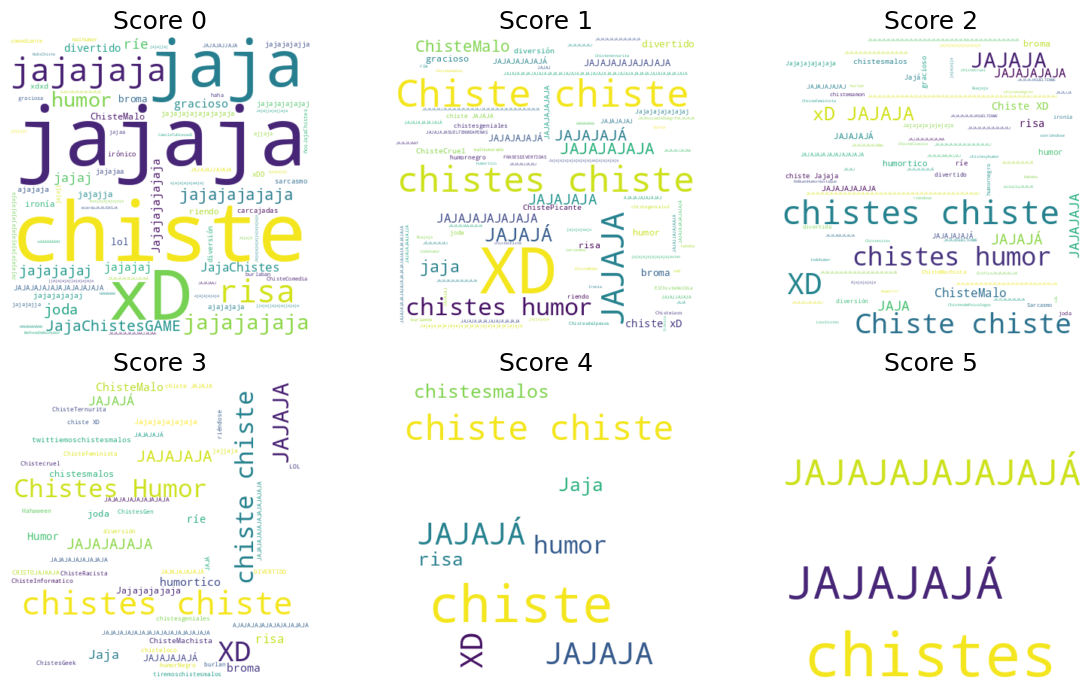

In [15]:
print("Nubes de tokens de humor presentes por clase:")
plot_wordclouds(tokens_per_class, all_tokens=False)

In [16]:
all_humor_tokens = []
for score_class in score_classes:
  all_humor_tokens.extend(tokens_per_class[score_class]['humor_tokens'])

all_humor_tokens = list(set(all_humor_tokens))

print(f"Tokens de humor encontrados: {len(all_humor_tokens)}")

Tokens de humor encontrados: 347


Se encuentran un 347 tokens distintos en el dataset con significado de humor como 'chiste', 'jajajá' o 'humor'.

A continuación se calculará el porcentaje de instancias en el dataset con y sin estos tokens de humor para cada clase según la tarea detección o clasificación.


In [17]:
def count_humor_tokens(text):
  count = 0
  tokens = custom_tokenizer(text)
  for token in tokens:
    if contains_humor_words(token):
      count += 1

  return count

In [18]:
processed_df2 = processed_df.copy()
processed_df2['humor_tokens'] = processed_df2['text'].apply(lambda col: count_humor_tokens(col))

no_humor_counts = processed_df2[processed_df2['humor_tokens'] == 0]
no_humor_counts = no_humor_counts['score'].value_counts()
no_humor_counts = no_humor_counts.sort_index()

humor_counts = processed_df2[processed_df2['humor_tokens'] > 0]
humor_counts = humor_counts['score'].value_counts()
humor_counts = humor_counts.sort_index()

In [19]:
def plot_bars_humor_tokens(humor_counts: pd.Series, no_humor_counts: pd.Series, classes_list: list[str]):
  """
  Presenta un gráfico de barras apilado para conteos de textos con/sin tokens de humor en el dataset.
  """
  total_counts = humor_counts + no_humor_counts
  no_humor_percentages = no_humor_counts / total_counts * 100
  humor_percentages = humor_counts / total_counts * 100

  bottom = pd.Series([0]*len(classes_list))

  figsize = (5, 5) if len(classes_list) == 2 else (8, 5)
  plt.figure(figsize=figsize)
  plt.bar(classes_list, no_humor_counts, bottom=bottom, color='skyblue', label='Instancias sin tokens de humor')

  for score_class in classes_list:
    x = score_class
    y = bottom[score_class] + no_humor_counts[score_class]/2
    y = 500 if y < 100 else y
    label = f'{no_humor_counts[score_class]:,} ({no_humor_percentages[score_class]:.1f}%)'
    plt.text(x, y, label, ha='center', va='center', fontsize=9, color='black')

  bottom += no_humor_counts
  plt.bar(classes_list, humor_counts, bottom=bottom, color='orange', label='Instancias con tokens de humor')

  for score_class in classes_list:
    x = score_class
    y = bottom[score_class] + humor_counts[score_class]/2
    y = 1000 if y < 200 else y
    label = f'{humor_counts[score_class]:,} ({humor_percentages[score_class]:.1f}%)'
    plt.text(x, y, label, ha='center', va='center', fontsize=9, color='black')

  bottom += humor_counts

  for score_class in classes_list:
    x = score_class
    y = bottom[score_class] + 400
    y = 1600 if y < 1000 else y
    label = f'{total_counts[score_class]:,}'
    plt.text(x, y, label, ha='center', va='center', fontsize=9, color='black', fontweight='bold')

  plt.xticks(classes_list)
  plt.xlabel('Clases')
  plt.ylabel('Instancias')
  task = 'Detección' if len(classes_list) == 2 else 'Clasificación'
  title = f'{task} - Instancias con/sin tokens de humor por clase'
  plt.title(title)
  plt.legend()
  plt.tight_layout()
  plt.show()

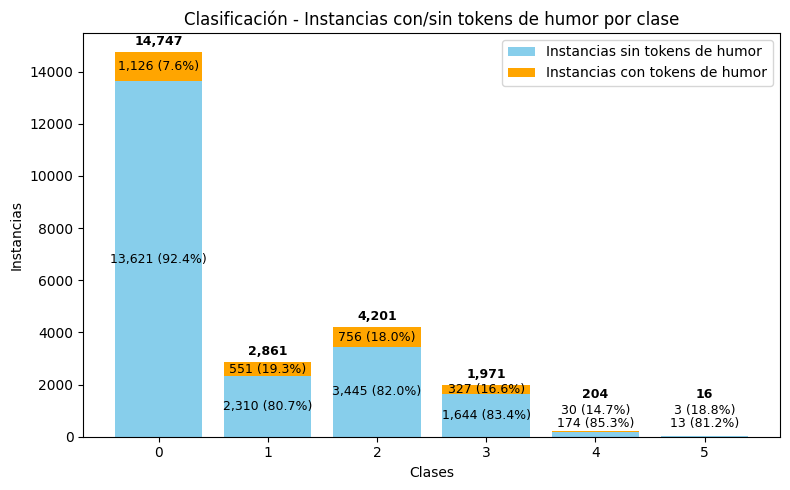

In [20]:
plot_bars_humor_tokens(humor_counts, no_humor_counts, score_classes)

Para la tarea de clasificación, de las instancias etiquetadas con un nivel de humor (del 1 al 5), entre un 14% al 19% aproximadamente tienen tokens de humor.


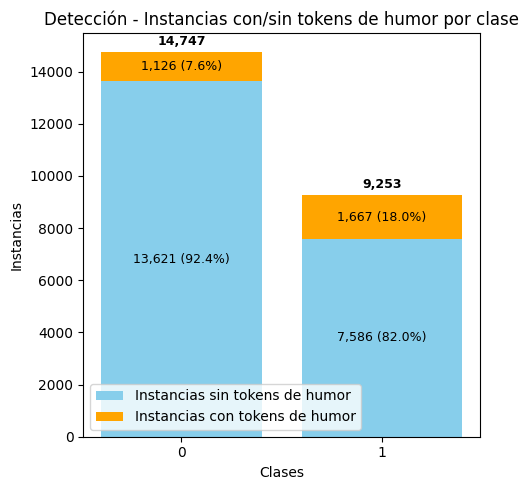

In [21]:
humor_counts2 = pd.Series([humor_counts.iloc[0], humor_counts.iloc[1:].sum()], index=[0, 1])
no_humor_counts2 = pd.Series([no_humor_counts.iloc[0], no_humor_counts.iloc[1:].sum()], index=[0, 1])

plot_bars_humor_tokens(humor_counts2, no_humor_counts2, detection_classes)

Para la tarea de detección, de las instancias etiquetadas como humor (clase 1), el 18% tienen tokens de humor.


## 2. Análisis de longitud de textos


In [22]:
processed_df3 = processed_df.copy()
processed_df3['length'] = processed_df2['text'].str.len()

In [23]:
def plot_histogram_text_lengths(data_df: pd.DataFrame, bins=10, class_label='0'):
  """
  Presenta un histograma de las longitudes de textos.
  """
  plt.figure(figsize=(8, 5))
  plt.hist(data_df['length'], bins=bins, color='firebrick', edgecolor='firebrick')
  title = f'Distribución de las longitudes de textos (Clase {class_label})'
  plt.title(title)
  plt.xlabel('Longitud de textos (caracteres)')
  plt.ylabel('Frecuencia')
  plt.grid(True)
  plt.show()

In [24]:
negative_lengths = processed_df3.copy()
negative_lengths = negative_lengths[negative_lengths['score'] == 0]

positive_lengths = processed_df3.copy()
positive_lengths = positive_lengths[positive_lengths['score'] >= 1]

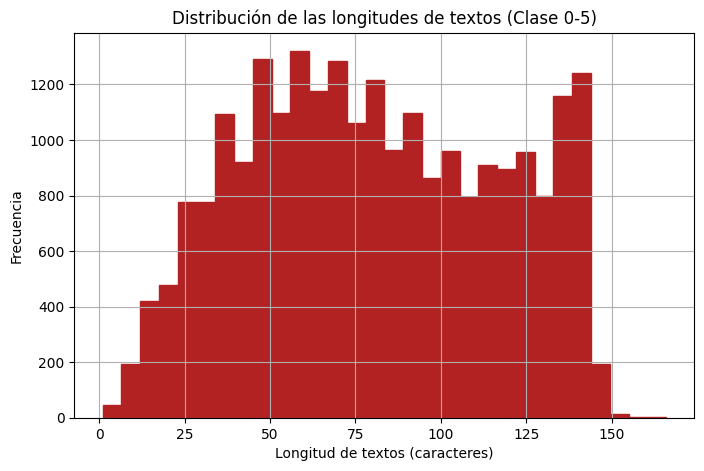

In [25]:
plot_histogram_text_lengths(processed_df3, bins=30, class_label='0-5')

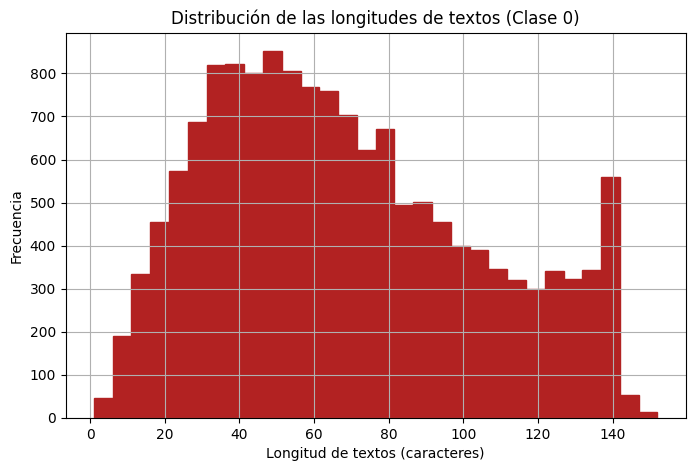

In [26]:
plot_histogram_text_lengths(negative_lengths, bins=30, class_label='0')

Del histograma se observa que la mayoría de textos clasificados como no humor (clase 0) tienen una longitud entre 20 y 100 caracteres. Algunos textos de longitud superior a 120 caracteres fueron etiquetados sin humor.


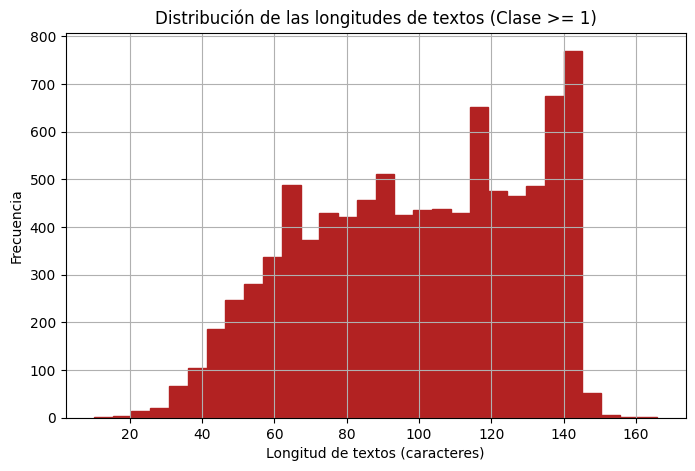

In [27]:
plot_histogram_text_lengths(positive_lengths, bins=30, class_label='>= 1')

Del histograma se observa que muchos textos de longitudes grandes superiores a 80 caracteres fueron etiquetados con algún nivel de humor (del 1 al 5).


## 3. Generación de dataset sintético


Se genera un dataset sintético de 2000 instancias de texto de tamaño aleatorio, con tokens de humor y otros tokens seleccionados del vocabulario encontrado en el dataset original. El objetivo es generar un dataset que equilibre la distribución de instancias con/sin tokens de humor.


In [28]:
all_tokens = []
for score_class in score_classes:
  all_tokens.extend(tokens_per_class[score_class]['tokens'])

all_tokens = list(set(all_tokens))

print(f"Tokens distintos en el dataset: {len(all_tokens)}")

Tokens distintos en el dataset: 41443


In [29]:
def generate_synthetic_df(all_tokens: list[str],
                          all_humor_tokens: list[str],
                          rows=10,
                          humor_tokens=1,
                          length_limits=(10, 30)) -> pd.DataFrame:
  """
  Genera un DataFrame con texto sintéticos creados a partir del vocabulario del dataset original
  y tokens de humor encontrados.
  """
  data = []

  for _ in range(rows):
    target_length = random.randint(length_limits[0], length_limits[1])
    random_humor_tokens = random.sample(all_humor_tokens, humor_tokens)
    text_value = " ".join(random_humor_tokens)
    random_token = random.choice(all_tokens)

    while len(text_value) + 1 + len(random_token) < target_length:
      text_value = text_value + " " + random_token
      random_token = random.choice(all_tokens)

    data.append({'text': text_value, 'score': 0})

  result_df = pd.DataFrame(data)
  return result_df

In [30]:
synthetic_df = generate_synthetic_df(all_tokens, all_humor_tokens, rows=2000, humor_tokens=1, length_limits=(85, 135))

synthetic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   score   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [31]:
synthetic_df.head(10)

,text,score
0,jjajajajajjajajajaja LETS cancelo Dejame Stran...,0
1,humor 💚 Pozole Investigaciones rosas Agradece ...,0
2,sarcasmo rompiendo asúmelo CARTULINA UANL expl...,0
3,#chistemamon COMISARIO pasandote cagarías subi...,0
4,chisteloco Mierda wila plantados latigazos líd...,0
5,#ChisteBobo dejad golpeó #temblorgt Enfin zagu...,0
6,JaJaJa Juventus 5s Tip trucutú hipocondriaco A...,0
7,🤔 hindues #NoConf Amiga #FollowMe Seguiremos M...,0
8,burla festejan cuánto BASURA #EnUnMundoPerfect...,0
9,jjajajajajjajajajaja Bridge Oxxo Tel #ABPKuhn ...,0


In [32]:
synthetic_dir_path = "../data/synthetic"
if not os.path.exists(synthetic_dir_path):
  os.makedirs(synthetic_dir_path)

synthetic_file_path = os.path.join(synthetic_dir_path, "haha_synthetic_train.csv")

synthetic_df.to_csv(synthetic_file_path, sep=',', encoding='utf-8', index=False)